In [1]:
import pandas as pd
df = pd.read_csv("cleaned_dataset3.csv")

In [2]:

df['sales_datetime'] = pd.to_datetime(df['sales_datetime']) 

weekly_sales = df.set_index('sales_datetime').resample('W')['total_price'].sum()

weekly_sales = weekly_sales[
    (weekly_sales.index >= '2017-01-01') & 
    (weekly_sales.index <= '2025-01-01')
]


df = df[df['sales_datetime'] > '2019-01-01']

In [3]:
from statsmodels.tsa.seasonal import STL

# Apply STL decomposition to the weekly sales time series
stl = STL(weekly_sales, period=52) #(52 weeks ≈ 1 year)
result = stl.fit()

# Extract the decomposed components from the STL result
trend = result.trend       # Long-term trend component (overall direction)
seasonal = result.seasonal # Seasonal component (repeating yearly patterns)
residual = result.resid    # Residual/noise component (irregular fluctuations)

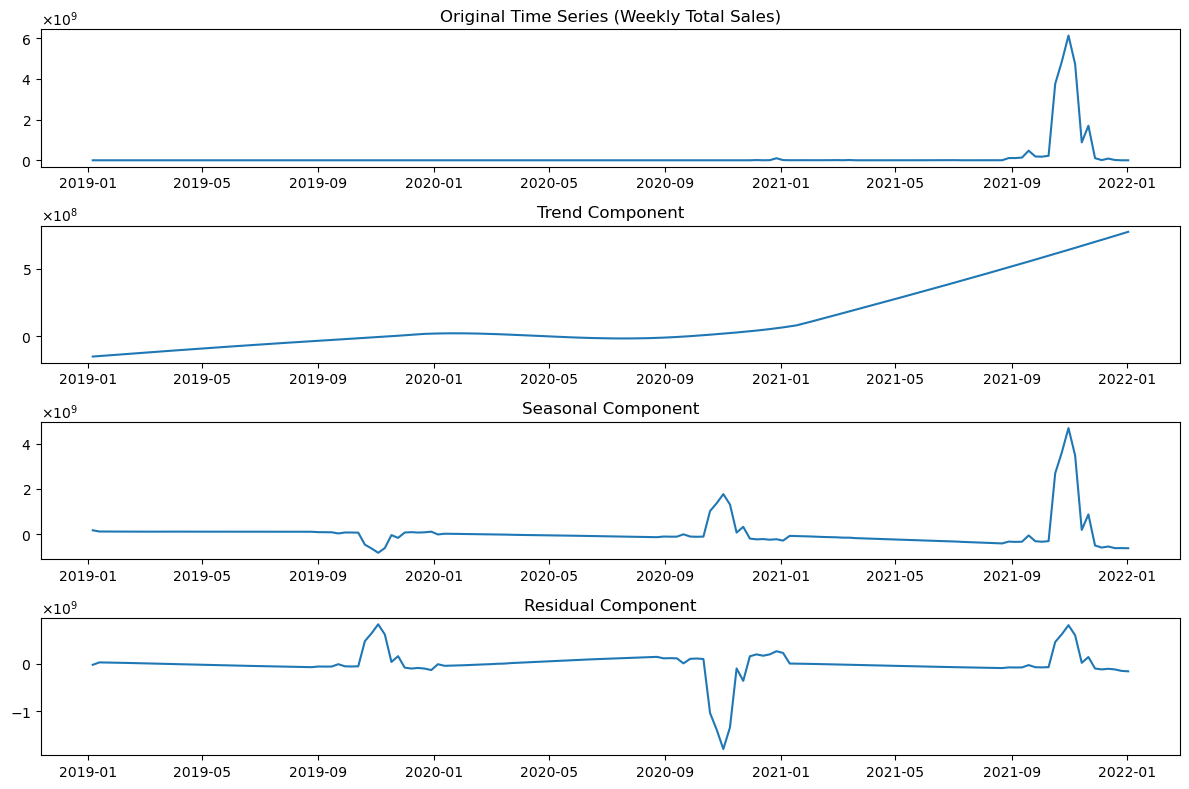

In [4]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

stl = STL(weekly_sales, period=52)
result = stl.fit()

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(weekly_sales)
plt.title("Original Time Series (Weekly Total Sales)")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title("Trend Component")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title("Seasonal Component")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title("Residual Component")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()


In [5]:
# Convert the 'sales_datetime' column to datetime format (if it's not already)
df['sales_datetime'] = pd.to_datetime(df['sales_datetime'])  

# Extract the year from the datetime column
df['year'] = df['sales_datetime'].dt.year

# Extract the month from the datetime column
df['month'] = df['sales_datetime'].dt.month

# Group data by year and month, summing the 'total_price' for each month
monthly_data = df.groupby(['year', 'month'])['total_price'].sum().unstack(fill_value=0)

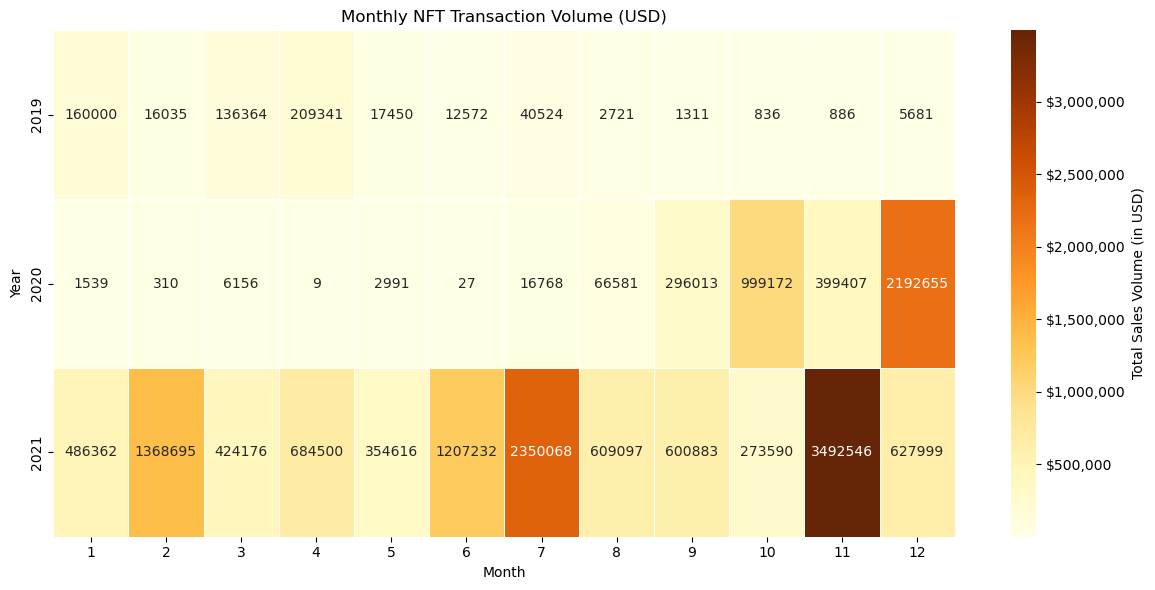

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df['sales_datetime'] = pd.to_datetime(df['sales_datetime'])

df['year'] = df['sales_datetime'].dt.year
df['month'] = df['sales_datetime'].dt.month

df_filtered = df[df['year'] < 2025]

# Aggregate the total USD price for each year-month combination
monthly_usd = df_filtered.groupby(['year', 'month'])['usd_price'].sum().unstack(fill_value=0)

# Create a heatmap to visualize the monthly total NFT transaction volume (in USD)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    monthly_usd,
    cmap='YlOrBr',           
    annot=True,               
    linewidths=0.5,           
    fmt=".0f",                
    cbar_kws={'label': 'Total Sales Volume (in USD)'}  
)

# Format the colorbar ticks with commas and dollar signs (e.g., $1,000)
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'${x:,.0f}')
)

plt.title("Monthly NFT Transaction Volume (USD)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [7]:
df['sales_datetime'] = pd.to_datetime(df['sales_datetime'])
df['year'] = df['sales_datetime'].dt.year

years = df['year'].unique()

years = sorted([y for y in years if 2018 <= y <= 2025])  # Example year filter range

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

cluster_results = {}


for year in years:
    df_year = df[df['year'] == year]    # Select data for the current year

    features = ['total_price', 'asset.num_sales']
    df_cluster = df_year[features].dropna()

    # Skip the year if there is no data available for clustering
    if len(df_cluster) < 1:
        print(f"Skipping {year} due to no available data.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    # Dynamically set the number of clusters to be no more than the number of available samples
    n_clusters = min(3, len(df_cluster))

    # Apply KMeans clustering 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)

    # Store clustering results for the current year
    cluster_results[year] = {
        'labels': kmeans.labels_,                  # Cluster labels for each sample
        'centroids': kmeans.cluster_centers_,      # Coordinates of cluster centers
        'data': df_cluster.copy(),                 # Original (non-normalized) input data
    }

    print(f"\nYear {year}:")
    print(pd.Series(kmeans.labels_).value_counts().sort_index())


Year 2019:
0    1435
1       8
2       3
Name: count, dtype: int64

Year 2020:
0     134
1    4627
2       7
Name: count, dtype: int64

Year 2021:
0    9858
1     171
2       2
Name: count, dtype: int64


C:\Users\zehra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


C:\Users\zehra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


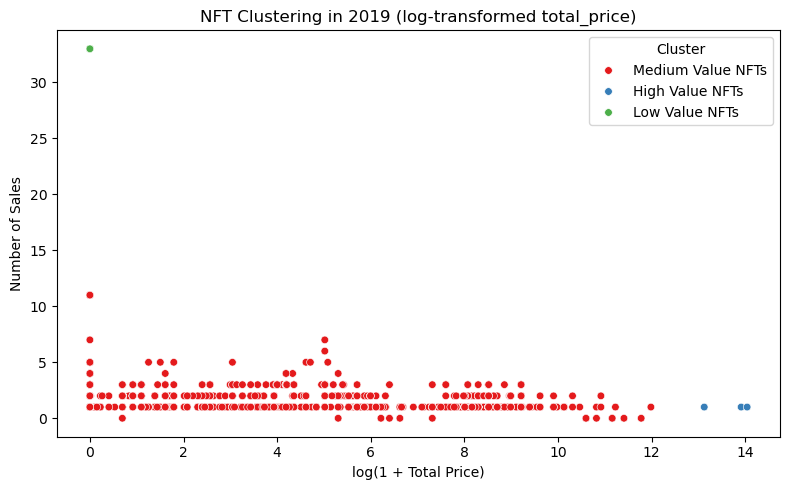

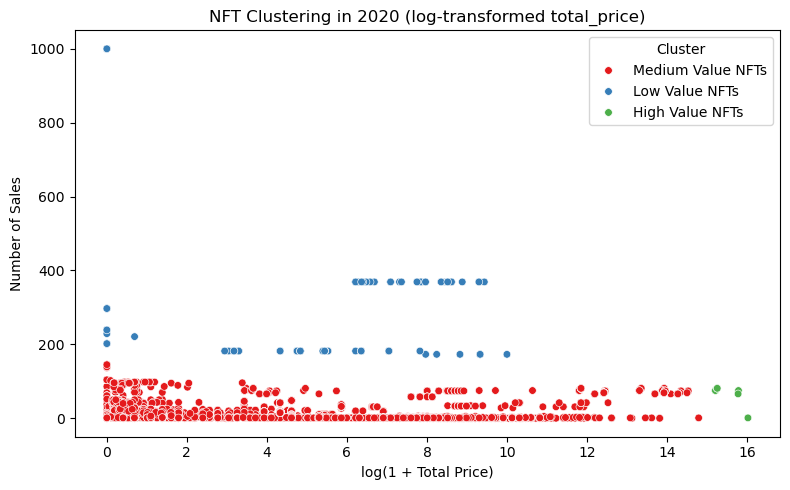

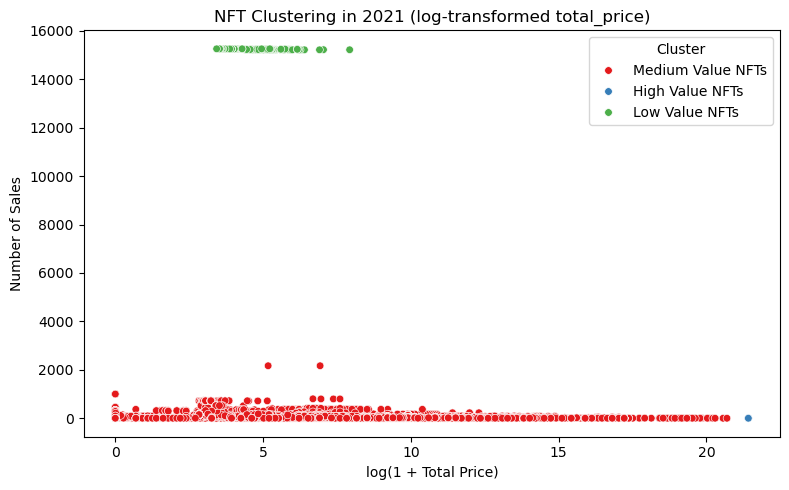

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


df['sales_datetime'] = pd.to_datetime(df['sales_datetime'])
df['year'] = df['sales_datetime'].dt.year

# 2. Define features to be used in clustering
features = ['total_price', 'asset.num_sales']

years = sorted(df['year'].dropna().unique())
years = [y for y in years if 2019 <= y <= 2021]

for year in years:
    df_year = df[df['year'] == year]
    df_cluster = df_year[features].dropna()

    if len(df_cluster) < 100:
        print(f"Skipping {year} due to insufficient data.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Assign cluster labels to the data
    df_cluster = df_cluster.copy()
    df_cluster['cluster'] = labels

    mean_prices = df_cluster.groupby('cluster')['total_price'].mean().sort_values()
    ordered_clusters = mean_prices.index.tolist()
    cluster_name_map = {
        ordered_clusters[0]: 'Low Value NFTs',
        ordered_clusters[1]: 'Medium Value NFTs',
        ordered_clusters[2]: 'High Value NFTs'
    }

    # Map numeric cluster labels to meaningful names
    df_cluster['cluster_named'] = df_cluster['cluster'].map(cluster_name_map)

    # Apply log transformation to total_price for better visualization
    df_cluster['total_price_log'] = np.log1p(df_cluster['total_price'])

    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df_cluster,
        x='total_price_log',
        y='asset.num_sales',
        hue='cluster_named',
        palette='Set1',
        s=30,
    )
    plt.title(f"NFT Clustering in {year} (log-transformed total_price)")
    plt.xlabel("log(1 + Total Price)")
    plt.ylabel("Number of Sales")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()